In [1]:
import numpy as np
import pandas as pd 
import re, string 
import spacy
import sys
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
SW = set(stopwords.words('english'))
from gensim.models import Word2Vec
%matplotlib inline

df = pd.read_csv('BBC news dataset.csv')

In [2]:
#Tokenize words in each article
tokenization = df['description'].apply(word_tokenize)

In [3]:
#Delete the stopwords, punctuation
def processing(x):
    x = x.lower()
    x = re.sub(r'\[.*?\]', '', x)
    x = re.sub(r'[%s]' % re.escape(string.punctuation), '', x)
    x = re.sub(r'\w*\d\w*', '', x)
    if len(x) > 2:
        return ' '.join(word for word in x.split() if word not in SW)

df_clean = pd.DataFrame(df.description.apply(lambda x: processing(x)))

In [4]:
#Lemmatize articles and clean text
nlp = spacy.load('en', disable=['ner', 'parser']) 

def lemmatizer(x):        
    sent = []
    doc = nlp(x)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['description']), axis=1)
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')

In [5]:
#Use word2vec in order to receive vectors
import sys

sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4)
                     
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)
w2v_model.init_sims(replace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


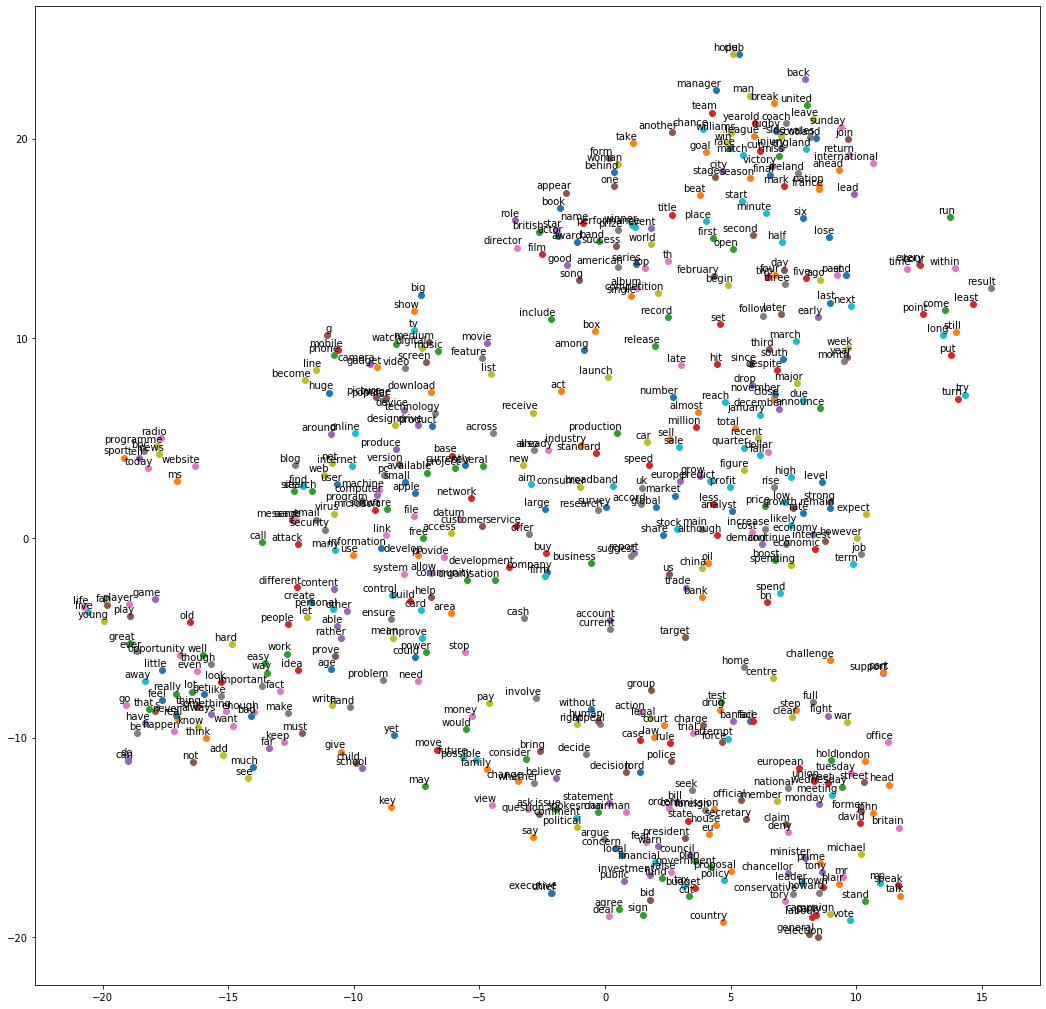

In [6]:
#Visualization of words in space
import sys
from matplotlib import pyplot as plt
%matplotlib inline

def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(w2v_model)

In [7]:
#There is no word 'America' in Vocabulary
'America' in w2v_model.wv.vocab

False